Not: Veri setini bu linkten indirebilirsiniz: https://www.kaggle.com/datasets/parisrohan/credit-score-classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ps = np.linspace(0.001,.9999,100)

def gini_index(ps):
    return 2* ps * (1-ps)

def misclass(ps):
    return 1 - np.maximum(ps,1-ps)

def entropy(ps):
    return -ps * np.log2(ps) - (1-ps)* np.log2(1-ps)

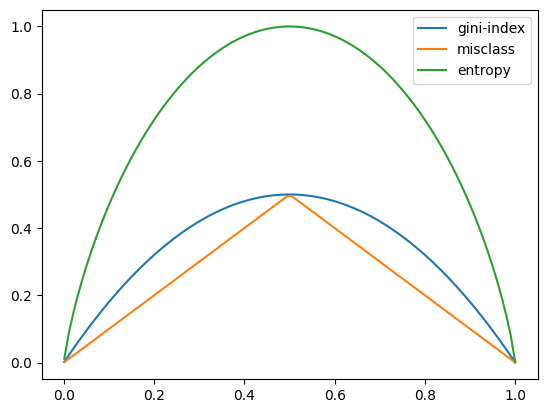

In [3]:
plt.plot(ps,gini_index(ps),label='gini-index')
plt.plot(ps,misclass(ps),label='misclass')
plt.plot(ps,entropy(ps),label='entropy')
plt.legend()
plt.show()

In [52]:
import pandas as pd 
train_df = pd.read_csv('train.csv')
len(train_df)

/var/folders/t_/wsj99tvd57j356g69px3zny00000gn/T/ipykernel_15480/262728531.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.


100000

In [53]:
train_df = train_df.dropna()

In [54]:
len(train_df)

53049

In [55]:
train_df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [56]:
dt_columns = ['Outstanding_Debt',
              'Monthly_Inhand_Salary',
              'Occupation',
              'Age',
               'Credit_Score']
y_column = 'Credit_Score'
train_df = train_df[dt_columns]

def convert_to_binary_classification(row):
    label = row['Credit_Score']
    
    if label == 'Poor':
        return label
    else: return "Good"

def convert_to_float(val)-> float:
    if type(val) == float:
        return round(val,3)
    val = val.strip('_')
    return round(float(val),3)

train_df['Credit_Score'] = train_df.apply(lambda row: convert_to_binary_classification(row), axis=1 )

for col in ['Outstanding_Debt','Monthly_Inhand_Salary','Age']:
    train_df[col] =  train_df.apply(lambda row: convert_to_float(row[col]), axis=1)

train_df['Age'] = train_df['Age'].clip(lower=18,upper=90) 


In [57]:
train_df['Age'].unique()

array([23., 28., 34., 54., 55., 33., 30., 24., 44., 45., 40., 32., 35.,
       36., 39., 37., 90., 31., 46., 41., 42., 48., 38., 43., 21., 22.,
       18., 19., 20., 27., 26., 47., 25., 29., 49., 51., 50., 52., 53.,
       56.])

In [58]:
train_df.query("Credit_Score=='Poor'")

,Outstanding_Debt,Monthly_Inhand_Salary,Occupation,Age,Credit_Score
57,1704.18,2611.115,Media_Manager,30.0,Poor
59,1704.18,2611.115,_______,30.0,Poor
63,1704.18,2611.115,Media_Manager,30.0,Poor
105,2602.69,519.129,Manager,39.0,Poor
107,2602.69,519.129,Manager,39.0,Poor
...,...,...,...,...,...
99994,502.38,3359.416,Mechanic,25.0,Poor
99995,502.38,3359.416,Mechanic,25.0,Poor
99996,502.38,3359.416,Mechanic,25.0,Poor
99997,502.38,3359.416,Mechanic,25.0,Poor


In [59]:
train_df['Outstanding_Debt'].iloc[0]

809.98

In [68]:
sample_size = 10000
viz_df = train_df.sample(n=sample_size)

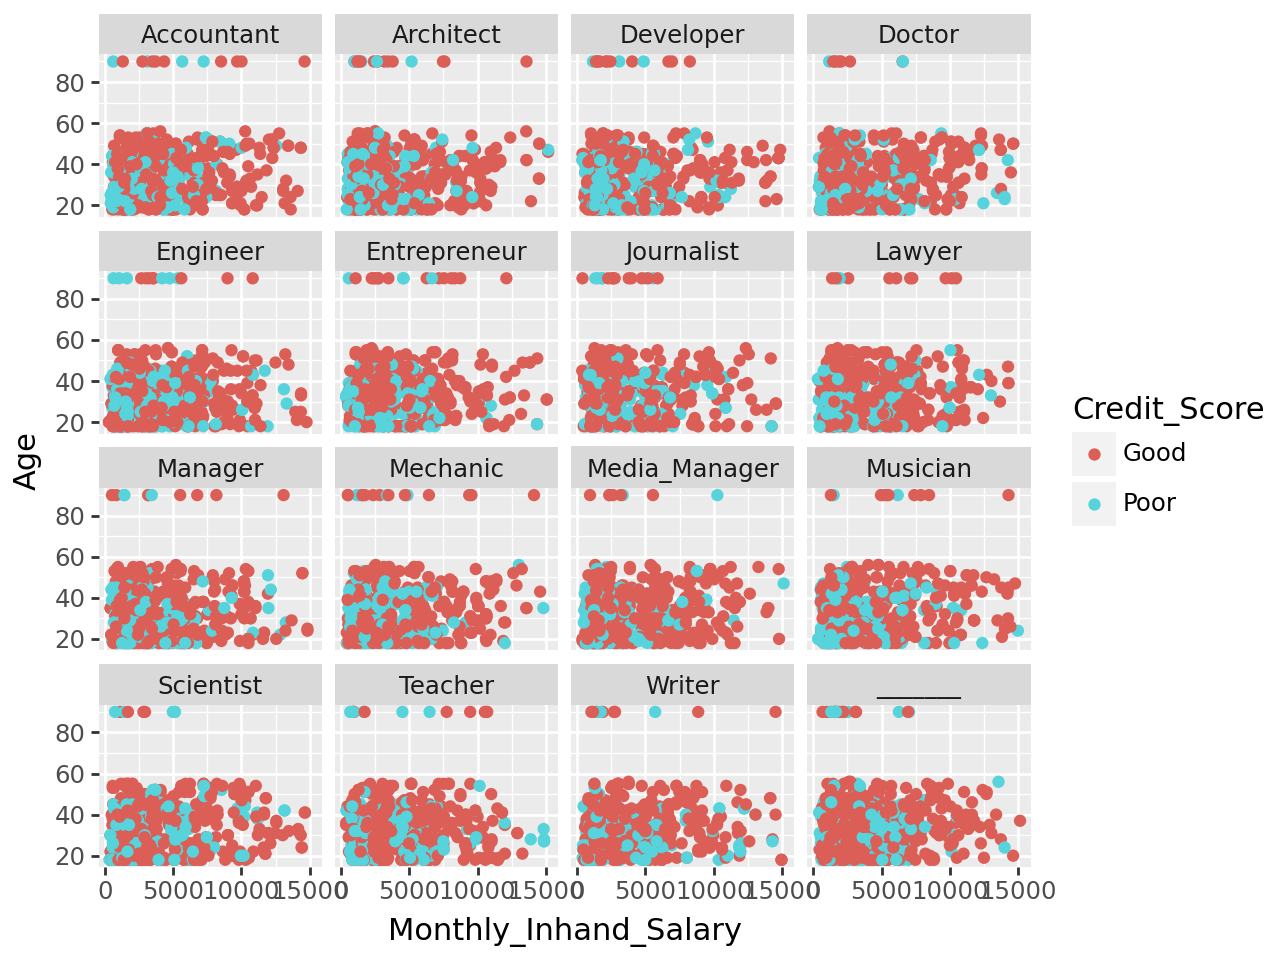

In [69]:
# Visualize
from plotnine import *
from plotnine.data import *

ggplot(data=viz_df) + geom_point(mapping=aes(x='Monthly_Inhand_Salary',y='Age',color="Credit_Score"))+ facet_wrap('Occupation')

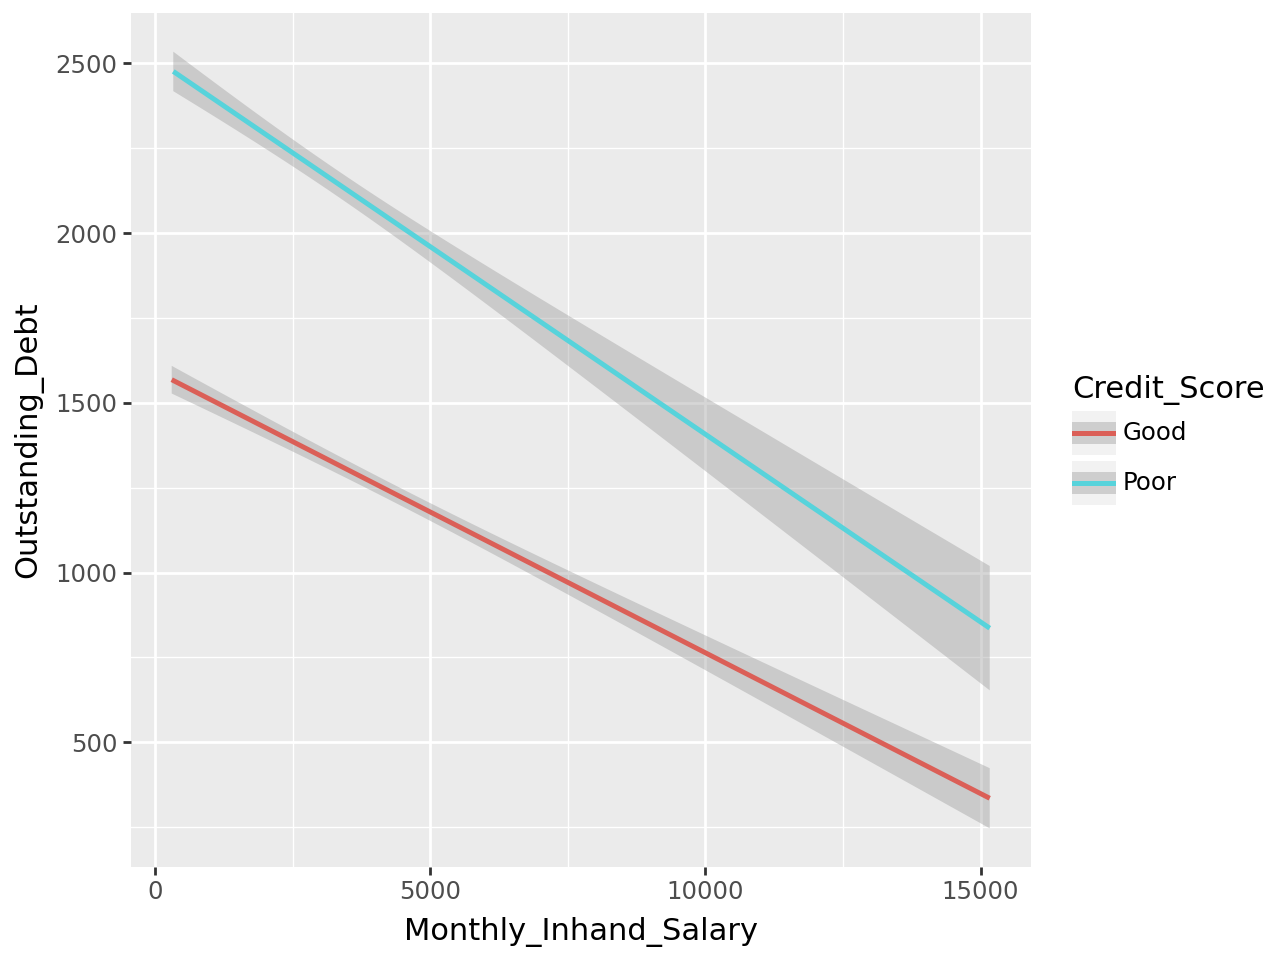

In [70]:
# se -> display confidence interval around smooth
# level -> confidence interval to use 0.95 by default

ggplot(data=viz_df) +\
geom_smooth(mapping=aes(x='Monthly_Inhand_Salary',
                        y='Outstanding_Debt',
                        color="Credit_Score",
                        ),se=True,level=0.99) 

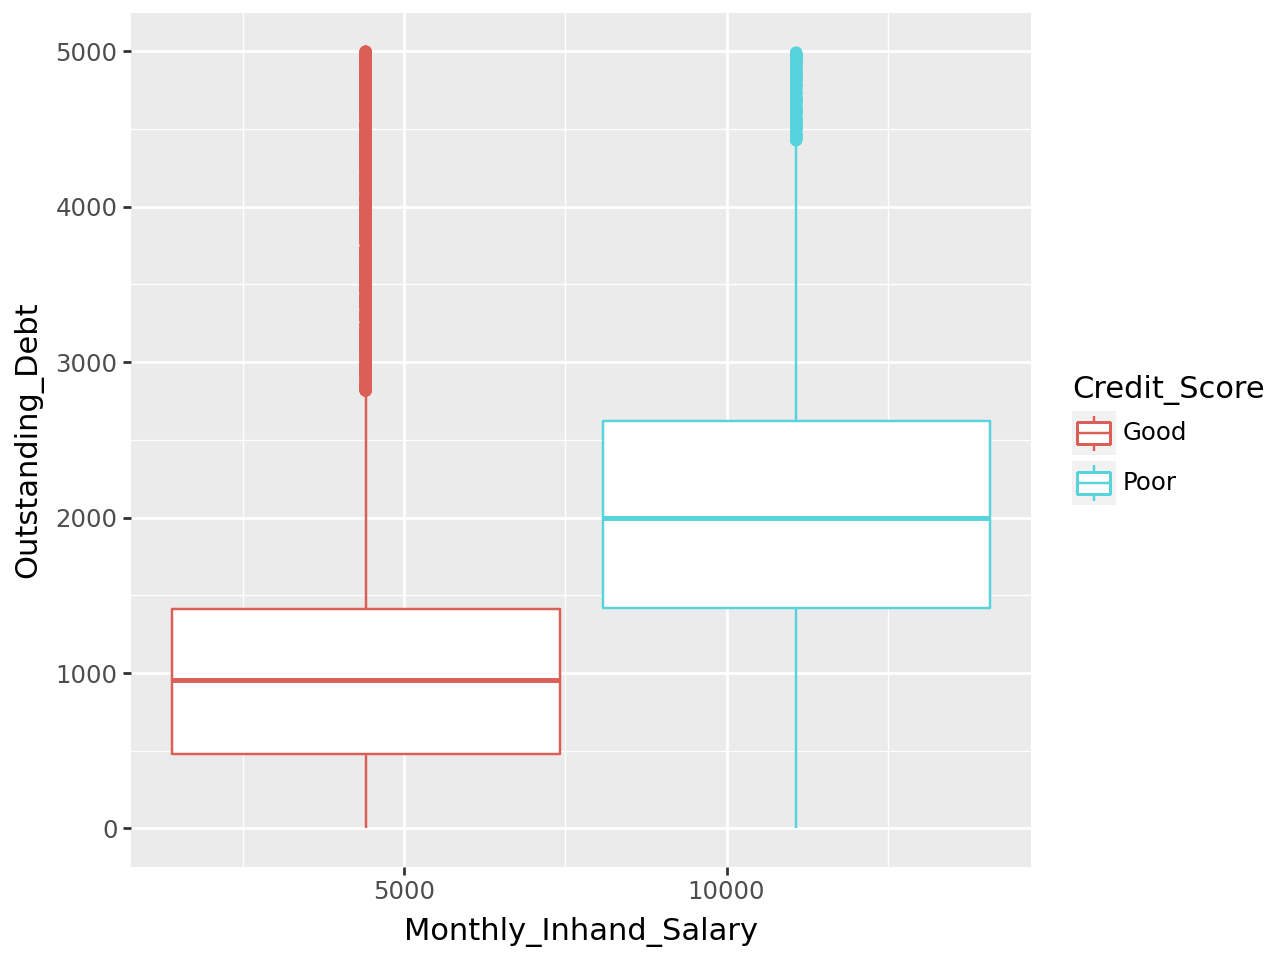

In [71]:
# use global mapping withing ggplot to avoid duplicate mention of same columns
ggplot(data=viz_df,mapping=aes(x='Monthly_Inhand_Salary',y='Outstanding_Debt')) +\
geom_boxplot(mapping=aes(color='Credit_Score'))

## Decision Tree from Scratch

In [72]:
sample_df = train_df.sample(n=100)

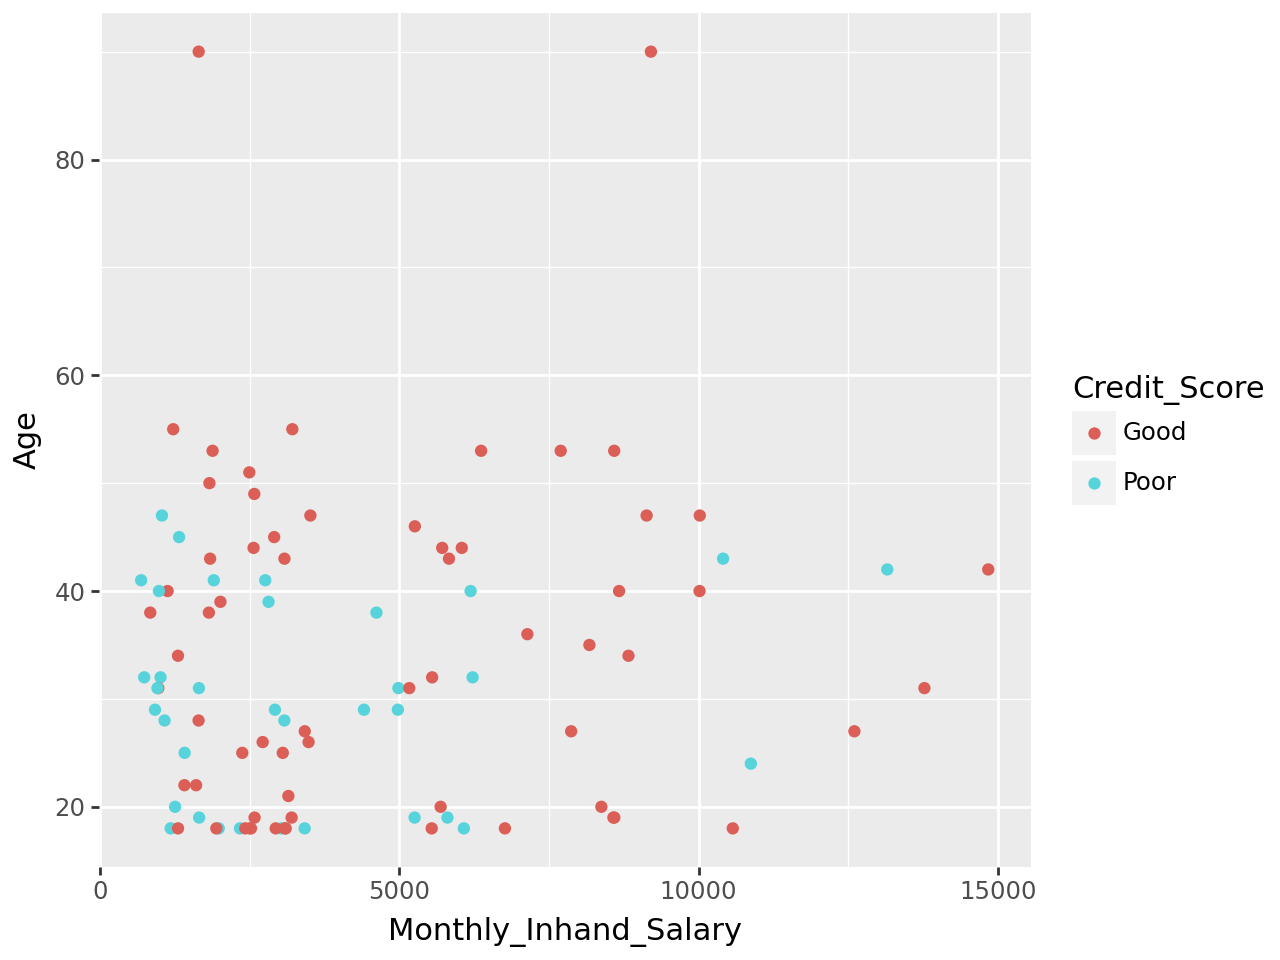

In [73]:
ggplot(data=sample_df) +\
geom_point(mapping=aes(x='Monthly_Inhand_Salary',y='Age',color="Credit_Score"))

In [74]:
# binary classification 
from typing import Literal


def node_entropy(node_df: pd.DataFrame) -> float:
    count = len(node_df)
    class_labels = node_df[y_column].unique()

    impurity = 0

    for c in class_labels:
        pc = len(node_df[node_df[y_column]==c])/count
        if pc > 0 :
            impurity -= pc * np.log2(pc)
    
    return impurity


def categorical_split(node_df: pd.DataFrame,col_name:str) -> float:
    all_categories = list(node_df[col_name].unique())
    total_size = len(node_df)

    total_impurity = 0
    for c in all_categories:
        
        split_df = node_df[node_df[col_name]==c]
        w = len(split_df)/total_size
        imp = node_entropy(split_df)
        print(c,imp,w)
        total_impurity+= w * imp

    return total_impurity

def binary_split(node_df:pd.DataFrame,col_name:str) -> float:
    all_values = list(set(node_df[col_name]))
    # Implement me


In [75]:
node_entropy(sample_df)

0.934068055375491

In [79]:
split1= sample_df[sample_df['Monthly_Inhand_Salary']<=7500]
split2= sample_df[sample_df['Monthly_Inhand_Salary']>7500]
(node_entropy(split1) * len(split1) + node_entropy(split2) *  len(split2)) /  len(sample_df)

0.898728536507015

In [83]:
split1.columns

Index(['Outstanding_Debt', 'Monthly_Inhand_Salary', 'Occupation', 'Age',
       'Credit_Score'],
      dtype='object')

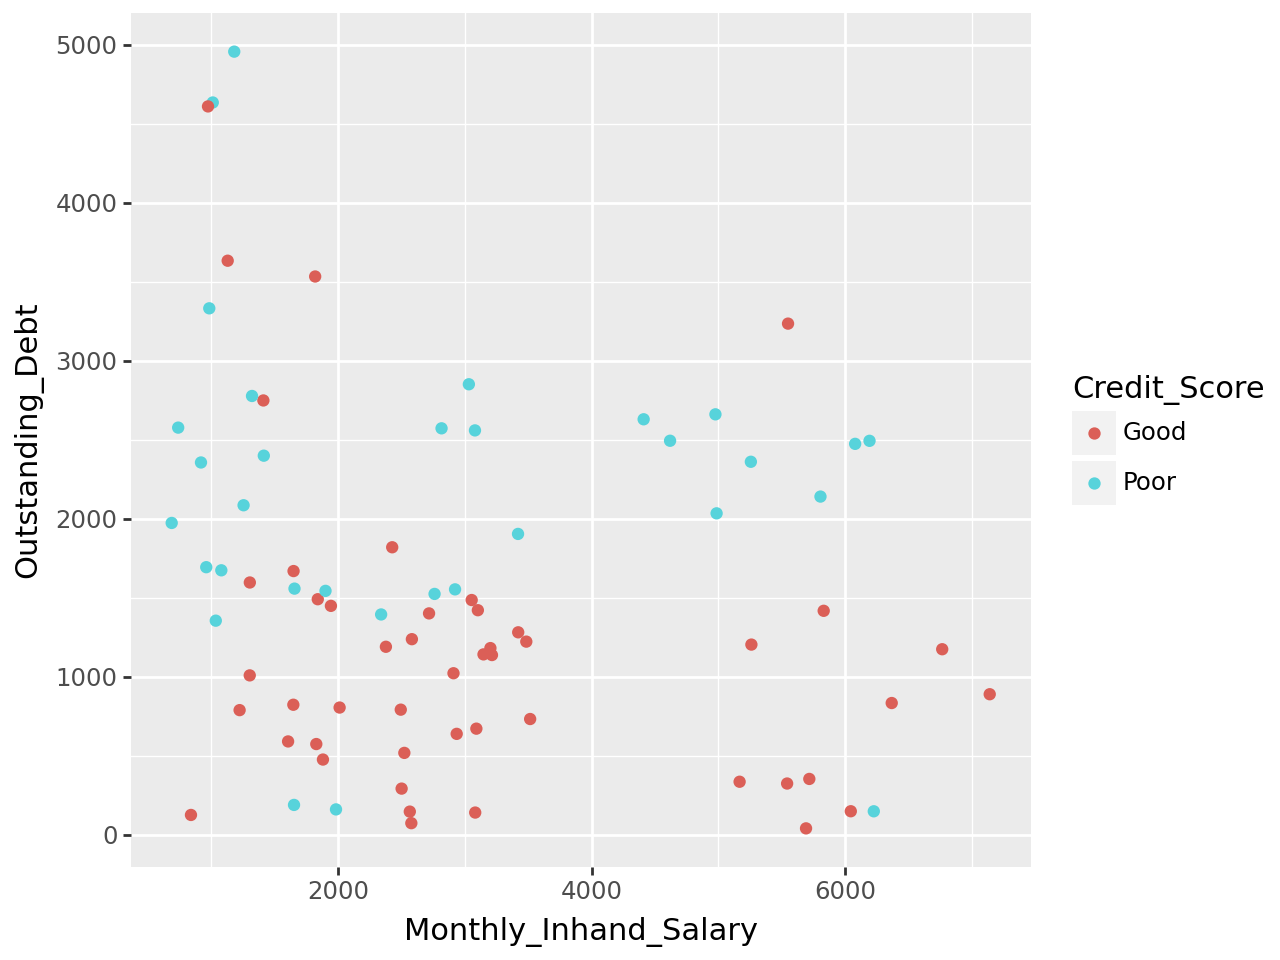

In [82]:
ggplot(data=split1) +\
geom_point(mapping=aes(x='Monthly_Inhand_Salary',y='Outstanding_Debt',color="Credit_Score"))

In [80]:
node_entropy(split1)

0.9709505944546686

In [84]:
split11= split1[split1['Outstanding_Debt']<=2000]
split12= split1[split1['Outstanding_Debt']>2000]
(node_entropy(split11) * len(split11) + node_entropy(split12) *  len(split12)) /  len(split1)

0.768695145433053

In [85]:
node_entropy(split11)

0.7817281222714539

In [86]:
node_entropy(split12)

0.7382848661434506

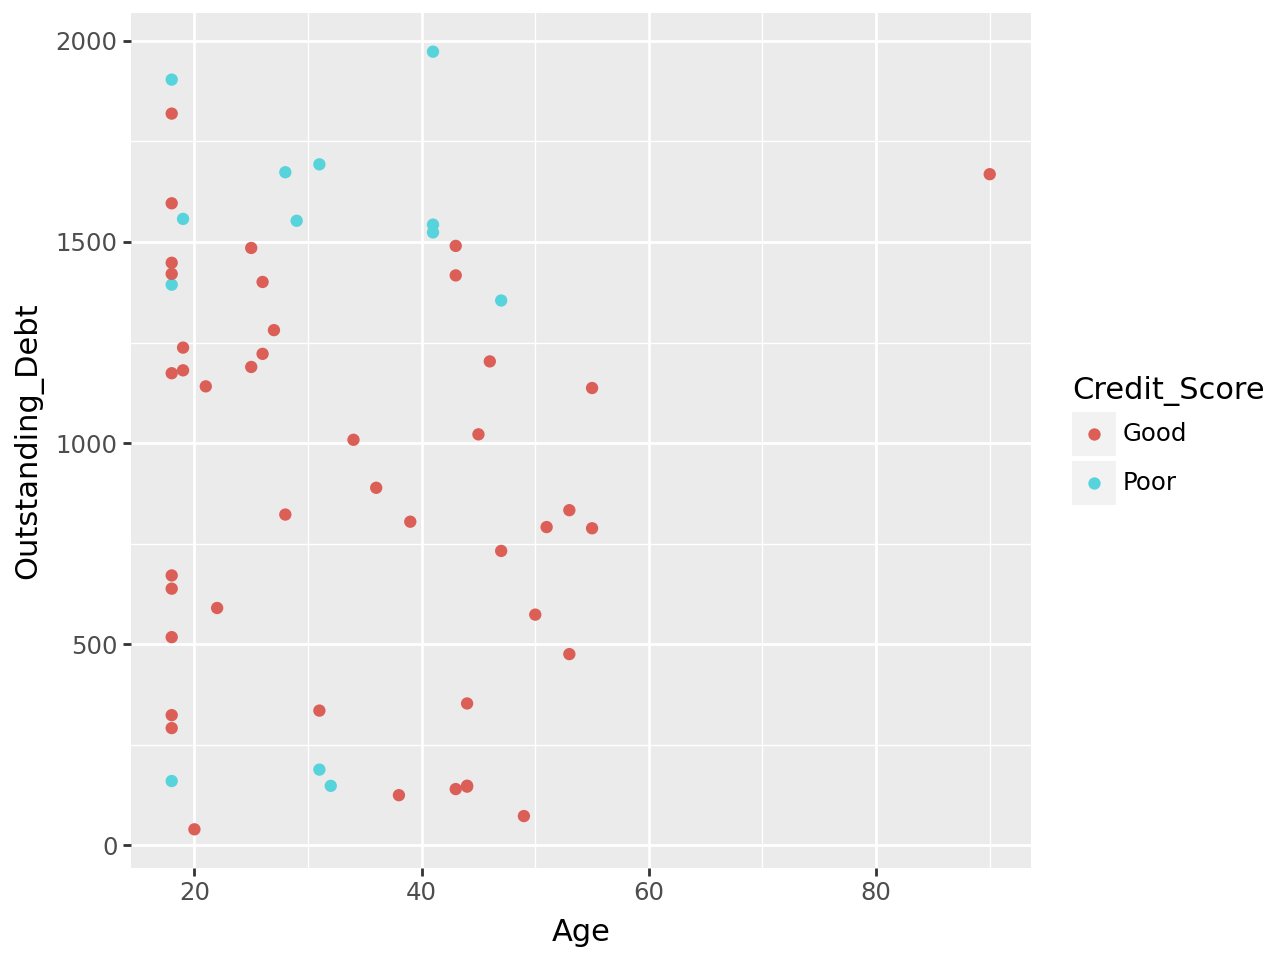

In [89]:
ggplot(data=split11) +\
geom_point(mapping=aes(x='Age',y='Outstanding_Debt',color="Credit_Score")) 

In [48]:
sample_df[sample_df['Occupation']=='Doctor']['Credit_Score'].value_counts()

Credit_Score
Poor    3
Good    3
Name: count, dtype: int64

In [50]:
categorical_split(sample_df,'Occupation')

Lawyer 0.0 0.03
Teacher 0.863120568566631 0.07
Mechanic 0.9709505944546686 0.05
Manager 0.9182958340544896 0.06
Accountant 0.9852281360342515 0.07
Musician 0.9182958340544896 0.03
Architect 0.9798687566511528 0.12
Entrepreneur 0.9798687566511528 0.12
Doctor 1.0 0.06
_______ 0.7642045065086203 0.09
Scientist 0.7219280948873623 0.05
Developer 0.9182958340544896 0.06
Media_Manager 0.0 0.07
Writer 0.9182958340544896 0.03
Journalist 0.9182958340544896 0.03
Engineer 0.9182958340544896 0.06


0.8259151261659281

In [51]:
node_entropy(sample_df)

0.9248187049730301

In [35]:
split1 = sample_df.query('Outstanding_Debt>2000')
split2 = sample_df.query('Outstanding_Debt<=2000')

In [36]:
(node_entropy(split1) * len(split1) + node_entropy(split2) *  len(split2)) /  len(sample_df)

0.7899569644246524